# E-Commerce Shipping Data

Authors: Dale DeFord, Brian Woo

## Overview
This project aims to develop a predictive model to forecast late shipments using historical data, enabling proactive measures to mitigate delays. We will collect and preprocess shipment data, train multiple machine learning models, and evaluate them based on precision, recall, F1 score, and accuracy.

## Business Problem
Fast and reliable delivery is a cornerstone of customer satisfaction in the shipping and logistics industry. Late deliveries can lead to dissatisfied customers, increased operational costs, and potential loss of business. FedEx, strives to ensure that packages reach their destinations on time. Despite our best efforts, a significant percentage of packages still arrive late, impacting our reputation and profitability.

### Objective
Develop a predictive model to accurately forecast whether a package will be delivered late. This model should help in identifying shipments at risk of delay, allowing us to take preemptive actions to mitigate these risks.

Key Metrics:
1. Recall: Minimizing the number of false negatives (packages predicted to be on time that are actually late).
2. Accuracy: Ensuring the model correctly predicts the delivery status.
3. F1 Score: Balancing precision and recall to optimize overall performance.
4. Precision: Minimizing the number of false positives (packages predicted to be late that are actually on time).

We will be tuning the models to maximize Recall score, while holding Accuracy at a reasonable score (60-65%)


## Source of Data
E-Commerce Shipping Data
- https://www.kaggle.com/datasets/prachi13/customer-analytics

### Content
The dataset used for model building contained 10999 observations of 12 variables.
The data contains the following information:

- ID: ID Number of Customers.
- Warehouse block: The Company have big Warehouse which is divided in to block such as A,B,C,D,E.
- Mode of shipment:The Company Ships the products in multiple way such as Ship, Flight and Road.
- Customer care calls: The number of calls made from enquiry for enquiry of the shipment.
- Customer rating: The company has rated from every customer. 1 is the lowest (Worst), 5 is the highest (Best).
- Cost of the product: Cost of the Product in US Dollars.
- Prior purchases: The Number of Prior Purchase.
- Product importance: The company has categorized the product in the various parameter such as low, medium, high.
- Gender: Male and Female.
- Discount offered: Discount offered on that specific product.
- Weight in gms: It is the weight in grams.
- Reached on time: It is the target variable, where 1 Indicates that the product has NOT reached on time and 0 indicates it has reached on time. (Its best to think of it as we want predict if the shipment will be late)

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, auc
from lazypredict.Supervised import LazyClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

# Understanding the Data Structure

In [2]:
# Load the dataset
df = pd.read_csv('data/Train.csv')

# Display the first few rows
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [3]:
df.shape

(10999, 12)

In [4]:
df.describe()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,10999.00,10999.00,10999.00,10999.00,10999.00,10999.00,10999.00,10999.00
mean,5500.00,4.05,2.99,210.20,3.57,13.37,3634.02,0.60
std,3175.28,1.14,1.41,48.06,1.52,16.21,1635.38,0.49
min,1.00,2.00,1.00,96.00,2.00,1.00,1001.00,0.00
25%,2750.50,3.00,2.00,169.00,3.00,4.00,1839.50,0.00
50%,5500.00,4.00,3.00,214.00,3.00,7.00,4149.00,1.00
75%,8249.50,5.00,4.00,251.00,4.00,10.00,5050.00,1.00
max,10999.00,7.00,5.00,310.00,10.00,65.00,7846.00,1.00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [6]:
# Check for missing values
df.isnull().sum()

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64

In [7]:
# check for duplicates
df.duplicated().sum()

0

# Cleaning the Data

In [8]:
# making column names lowercase
df.columns = df.columns.str.lower()

In [9]:
# changing reached.on.time_y.n to reached_on_time
df.rename(columns={'reached.on.time_y.n':'reached_on_time'}, inplace=True)

In [10]:
numerical_cols = ['customer_care_calls', 'customer_rating', 'cost_of_the_product', 
                      'prior_purchases', 'discount_offered', 'weight_in_gms']

categorical_cols = ['warehouse_block', 'mode_of_shipment', 'product_importance', 'gender' ]

## Correlation Analysis

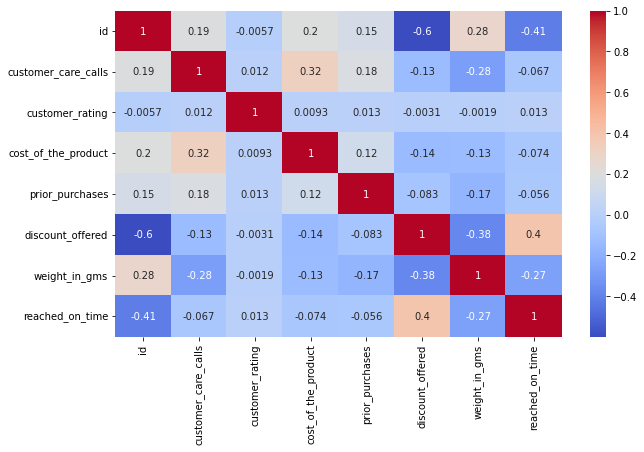

In [11]:
# correlation matrix heatmap for numerical columns
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

## Outlier Detection

In [12]:
# function to find outliers
def find_outliers_iqr(dataframe, column):
    """
    Find the outliers in the column using the IQR method
    -
    Input: 
        dataframe: Pandas DataFrame
        column: str
    -
    Output:
        Prints:
            - The number of outliers in the column.
            - The percentage of outliers in the column.
    """
    q1 = dataframe[column].quantile(0.25)
    q3 = dataframe[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    
    outliers = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]
    percent_outliers = len(outliers) * 100 / len(dataframe)
    
    print(f"Number of outliers: {len(outliers)}")
    print(f"Percentage of outliers: {percent_outliers:.2f}%")

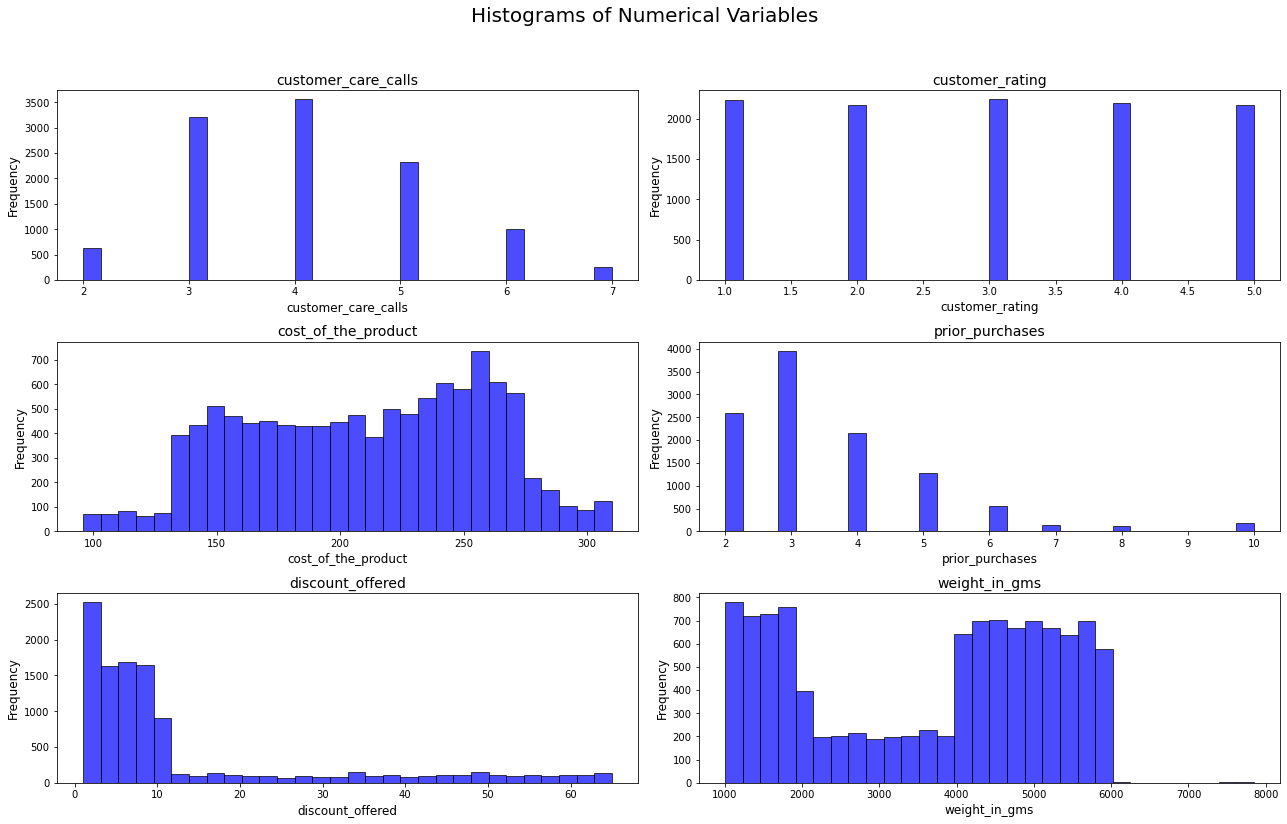

In [13]:
# Plot histograms for each numerical variable
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 12))
fig.suptitle('Histograms of Numerical Variables', fontsize=20)

for i, ax in enumerate(axes.flatten()):
    if i < len(numerical_cols):
        ax.hist(df[numerical_cols[i]], bins=30, color='blue', edgecolor='black', alpha=0.7)
        ax.set_title(numerical_cols[i], fontsize=14)
        ax.set_xlabel(numerical_cols[i], fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [14]:
# check for outliers in all numerical columns
for col in numerical_cols:
    print(f"Outliers in {col}")
    find_outliers_iqr(df, col)
    print("\n")

Outliers in customer_care_calls
Number of outliers: 0
Percentage of outliers: 0.00%


Outliers in customer_rating
Number of outliers: 0
Percentage of outliers: 0.00%


Outliers in cost_of_the_product
Number of outliers: 0
Percentage of outliers: 0.00%


Outliers in prior_purchases
Number of outliers: 1003
Percentage of outliers: 9.12%


Outliers in discount_offered
Number of outliers: 2209
Percentage of outliers: 20.08%


Outliers in weight_in_gms
Number of outliers: 0
Percentage of outliers: 0.00%




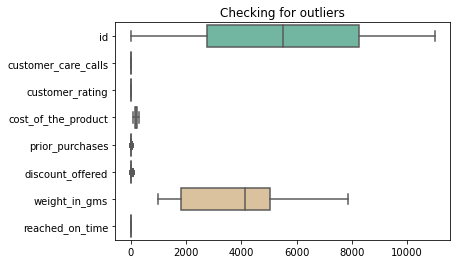

In [15]:
# check for outliers
sns.boxplot(data=df, orient='h', palette='Set2')
plt.title('Checking for outliers')
plt.show()

# Data Visualization

<function seaborn.categorical.countplot(data=None, *, x=None, y=None, hue=None, order=None, hue_order=None, orient=None, color=None, palette=None, saturation=0.75, width=0.8, dodge=True, ax=None, **kwargs)>

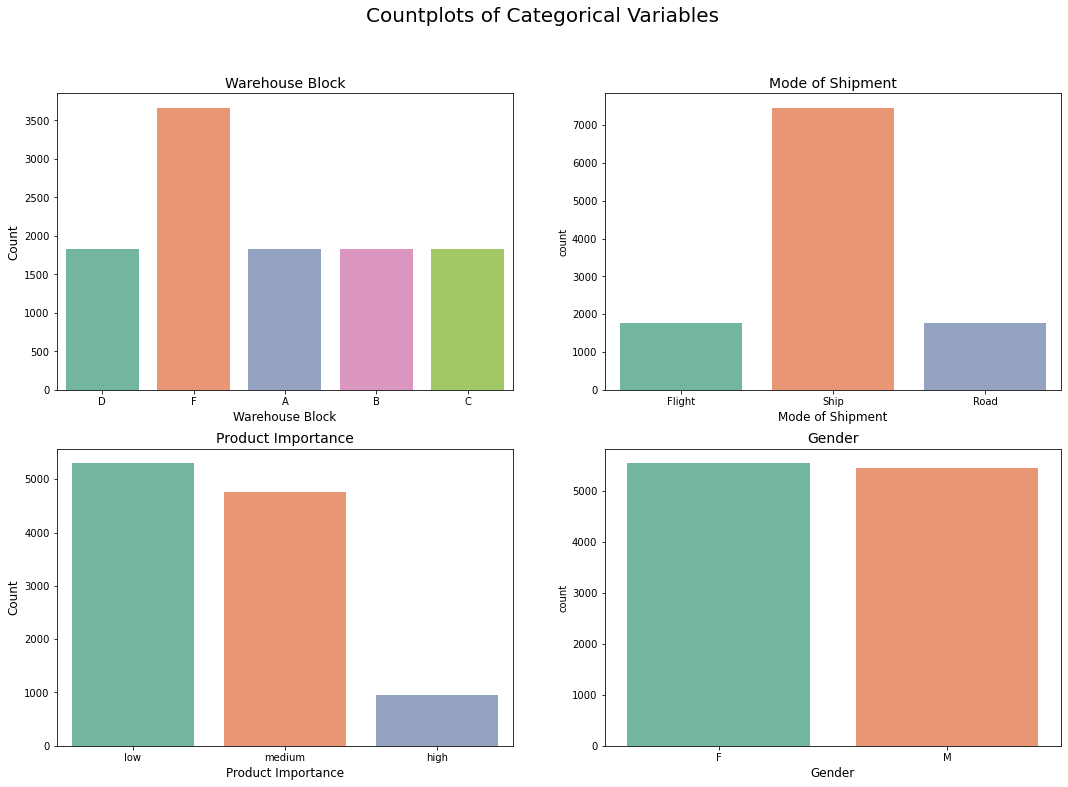

In [16]:
# countplot for categorical columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
fig.suptitle('Countplots of Categorical Variables', fontsize=20)

sns.countplot(x='warehouse_block', data=df, ax=axes[0, 0], palette='Set2')
axes[0, 0].set_title('Warehouse Block', fontsize=14)
axes[0, 0].set_xlabel('Warehouse Block', fontsize=12)
axes[0, 0].set_ylabel('Count', fontsize=12)

sns.countplot(x='mode_of_shipment', data=df, ax=axes[0, 1], palette='Set2')
axes[0, 1].set_title('Mode of Shipment', fontsize=14)
axes[0, 1].set_xlabel('Mode of Shipment', fontsize=12)

sns.countplot(x='product_importance', data=df, ax=axes[1, 0], palette='Set2')
axes[1, 0].set_title('Product Importance', fontsize=14)
axes[1, 0].set_xlabel('Product Importance', fontsize=12)
axes[1, 0].set_ylabel('Count', fontsize=12)

sns.countplot(x='gender', data=df, ax=axes[1, 1], palette='Set2')
axes[1, 1].set_title('Gender', fontsize=14)
axes[1, 1].set_xlabel("Gender", fontsize=12)

sns.countplot

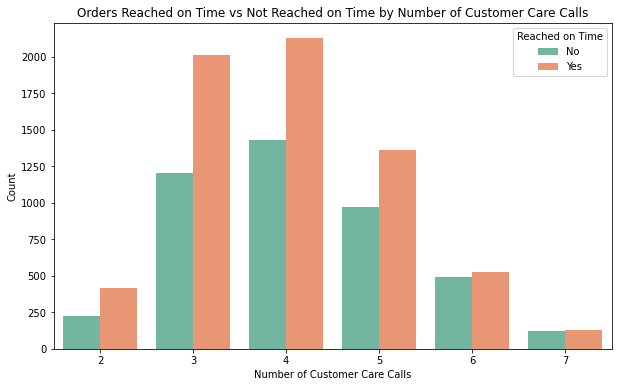

In [17]:
# orders reached on time vs not reached on time by number of customer care calls
plt.figure(figsize=(10,6))
sns.countplot(x='customer_care_calls', hue='reached_on_time', data=df, palette='Set2')
plt.title('Orders Reached on Time vs Not Reached on Time by Number of Customer Care Calls')
plt.xlabel('Number of Customer Care Calls')
plt.ylabel('Count')
plt.legend(title='Reached on Time', labels=['No', 'Yes'])
plt.show()

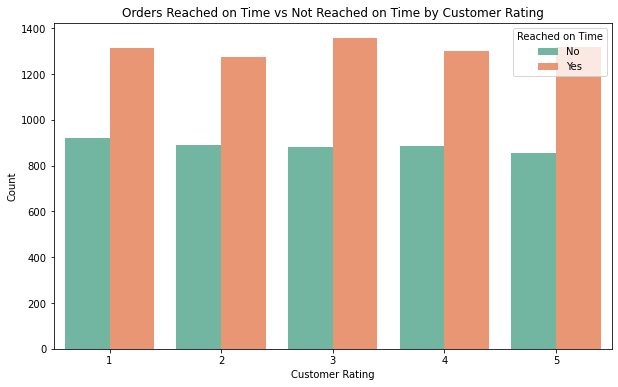

In [18]:
# orders reached on time vs not reached on time by customer rating
plt.figure(figsize=(10,6))
sns.countplot(x='customer_rating', hue='reached_on_time', data=df, palette='Set2')
plt.title('Orders Reached on Time vs Not Reached on Time by Customer Rating')
plt.xlabel('Customer Rating')
plt.ylabel('Count')
plt.legend(title='Reached on Time', labels=['No', 'Yes'])
plt.show()

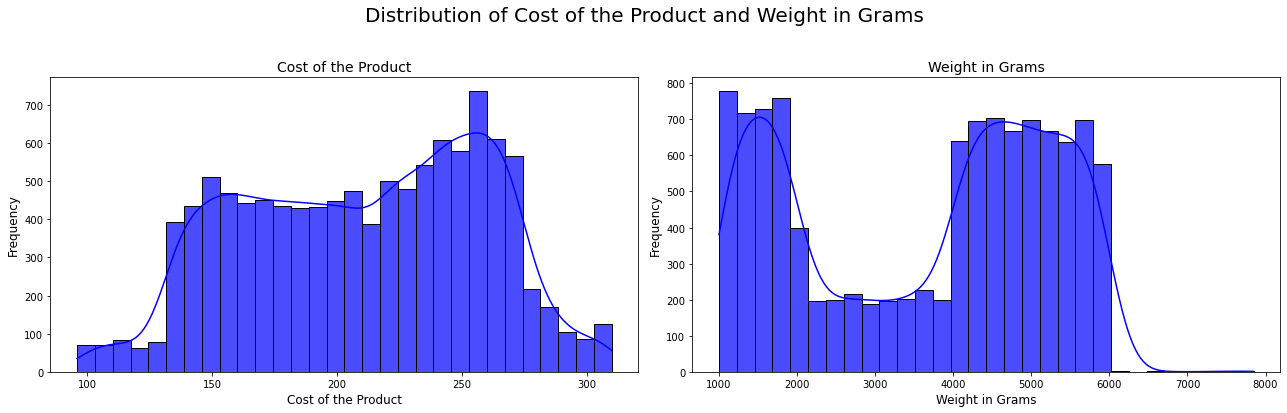

In [19]:
# displot cost of product and weight in gms
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
fig.suptitle('Distribution of Cost of the Product and Weight in Grams', fontsize=20)

sns.histplot(df['cost_of_the_product'], bins=30, kde=True, color='blue', edgecolor='black', alpha=0.7, ax=axes[0])
axes[0].set_title('Cost of the Product', fontsize=14)
axes[0].set_xlabel('Cost of the Product', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)

sns.histplot(df['weight_in_gms'], bins=30, kde=True, color='blue', edgecolor='black', alpha=0.7, ax=axes[1])
axes[1].set_title('Weight in Grams', fontsize=14)
axes[1].set_xlabel('Weight in Grams', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

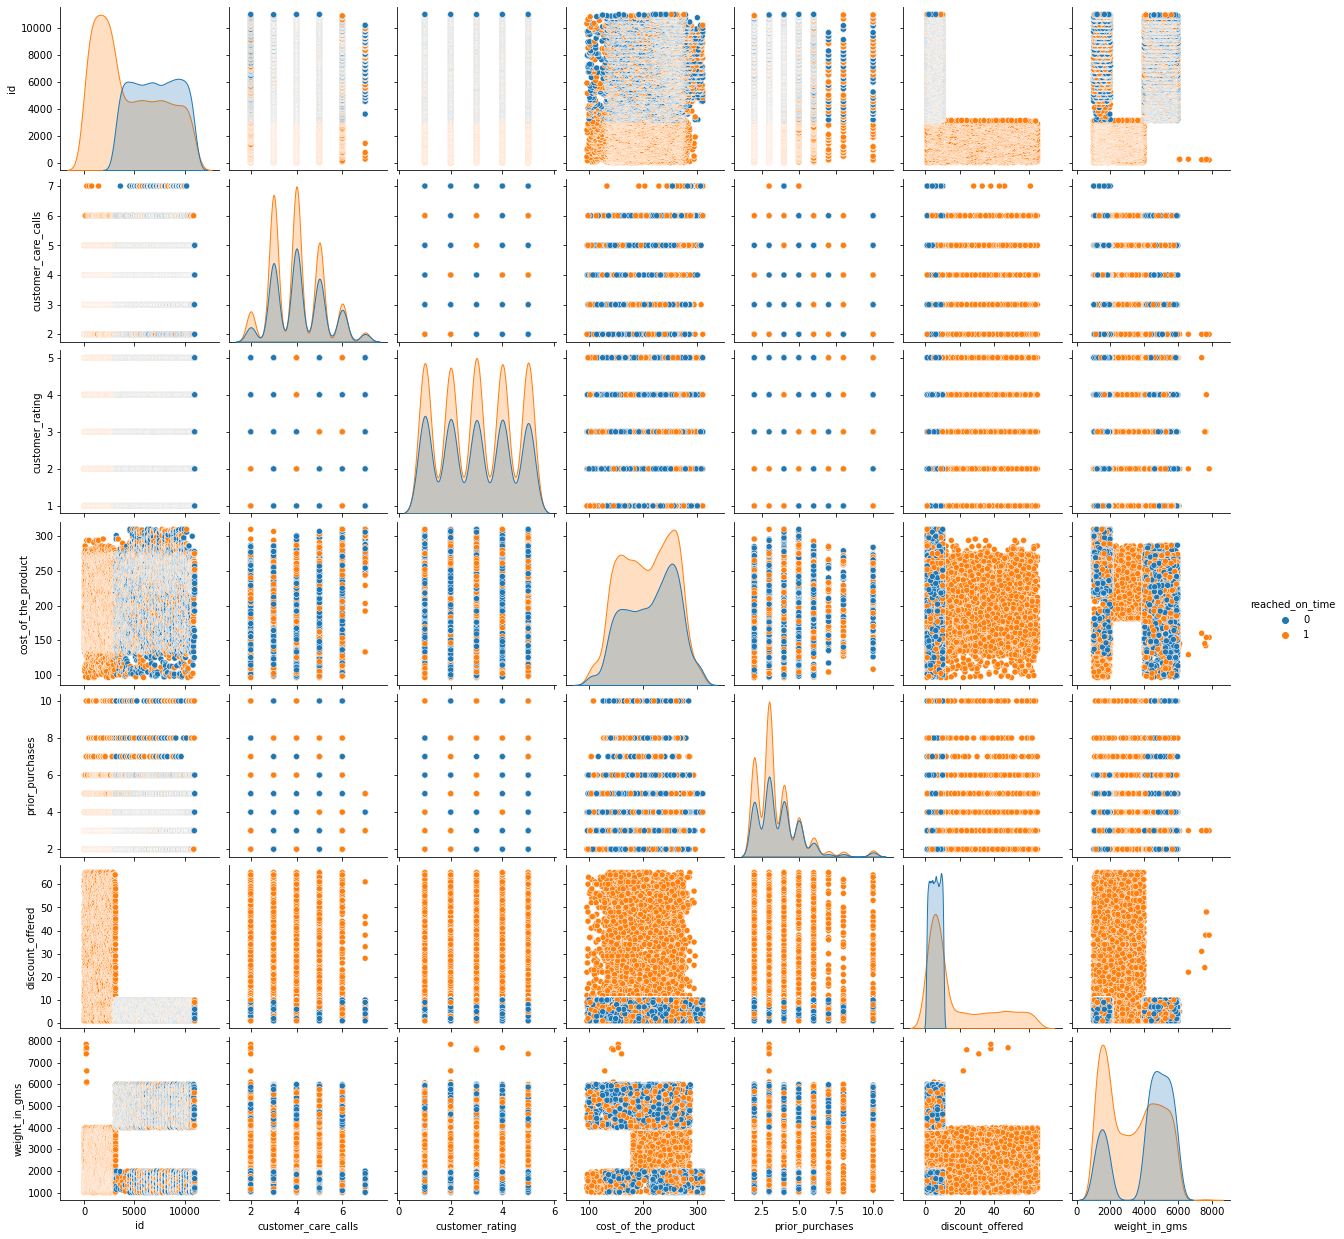

In [20]:
# Creating pairplots for the numerical columns with the hue as the target variable
sns.pairplot(df, hue='reached_on_time', diag_kind='kde')
plt.show()

In [21]:
# Whats going on with the discount offered?  Strange distribution of the target variable
print(df[df['discount_offered'] >= 10]['reached_on_time'].value_counts())
print(df[df['discount_offered'] > 10]['reached_on_time'].value_counts())

1    3048
0     459
Name: reached_on_time, dtype: int64
1    2647
Name: reached_on_time, dtype: int64


### Problem: for 'Discount_offered' > $10, there are no deliveries that were on time!
- This suggests that any 'Discount_offered' > 10 was given after the knowledge that the delivery was not going to be on time, thus can't be used as a predictor.
- Using 'Discount_offered' as an X variable could be considered a form of data leakage, if the discount was offered as a result of delivery status

In [22]:
# dropping the column but keeping the rows
df = df.drop(columns='discount_offered', axis=1)

1    6563
0    4436
Name: reached_on_time, dtype: int64


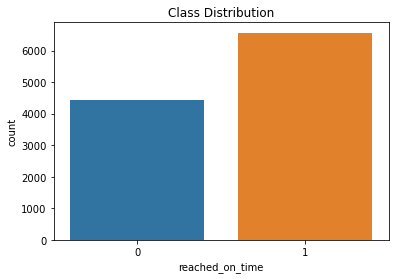

In [23]:
# Check the distribution of the target variable
print(df['reached_on_time'].value_counts())
sns.countplot(x=df['reached_on_time'])
plt.title('Class Distribution')
plt.show()

### Slight imbalance in the target variable, will keep this in mind during model tuning

In [24]:
# Removing the small number of extreme outliers in weight_in_gms
df = df[df['weight_in_gms'] <= 6000]

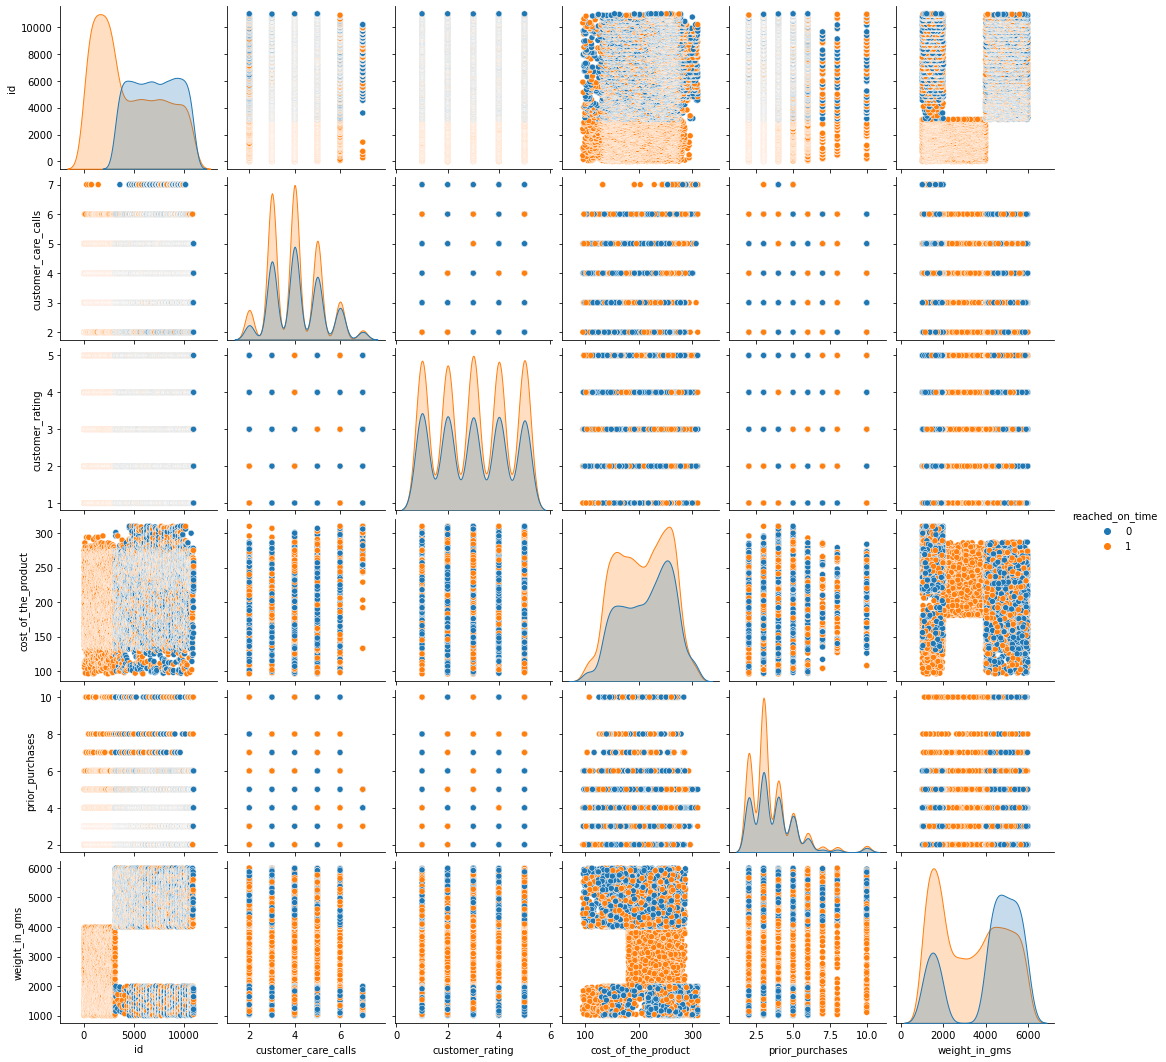

In [25]:
# Look at the pairplots again
sns.pairplot(df, hue='reached_on_time', diag_kind='kde')
plt.show()

### It appears that the data is not pulled from a normal distribution, with respect to the weight_in_grams.  For instance:
- Up until ID 3135, there are essentiall zero values above 4000.  Then after ID~3135 there are only values 1-2k and 4-6k
- Cost_of_the_product has a hole for the 2-4k wieght range between 0 and ~175, then again for >2k wieght for cost > ~275
- Most importantly, there is a hole in our target variable Reached.on.Time_Y.N=0 for weights ~2000 to 4000 and ID 0 ~3000!

Due to this apparent strangeness/missingness in the distribution, we should spend more time on the Business Understanding <-> Data Understanding stage of CRISP-DM data mining process.  For now, we will keep the weight_in_grams column.

In [26]:
# dropping unnecessary columns
df.drop(['id'], axis=1, inplace=True)

---

## Predictive Modeling

---

## Splitting Data into Training and Testing Sets

In [27]:
# Define features and target variable
X = df.drop(columns='reached_on_time', axis=1)
y = df['reached_on_time']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# Updated Columns
numerical_cols = ['customer_care_calls', 'customer_rating', 'cost_of_the_product', 
                      'prior_purchases', 'weight_in_gms']

categorical_cols = ['warehouse_block', 'mode_of_shipment', 'product_importance', 'gender' ]

### Baseline Model: Logistic Regression

In [29]:
# preprocess numerical data
numerical_transformer = StandardScaler()

# preprocess categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [30]:
# Create the logistic regression pipeline
baseline_logistic_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=100))
])

# Train the model
baseline_logistic_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['customer_care_calls',
                                                   'customer_rating',
                                                   'cost_of_the_product',
                                                   'prior_purchases',
                                                   'weight_in_gms']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['warehouse_block',
                                                   'mode_of_shipment',
                                                   'product_importance',
                                                   'gender'])])),
                ('classifier', LogisticRegression(random_state=42))])

In [31]:
# Make predictions
y_pred_baseline = baseline_logistic_model.predict(X_test)
y_prob_baseline = baseline_logistic_model.predict_proba(X_test)[:, 1]

In [32]:
# Calculate roc_auc metric
baseline_roc_auc = roc_auc_score(y_test, y_pred_baseline)

# Classification report
print('Baseline Logistic Regression Model Metrics:')
print(classification_report(y_test, y_pred_baseline))

Baseline Logistic Regression Model Metrics:
              precision    recall  f1-score   support

           0       0.56      0.40      0.47       890
           1       0.66      0.79      0.72      1309

    accuracy                           0.63      2199
   macro avg       0.61      0.59      0.59      2199
weighted avg       0.62      0.63      0.62      2199



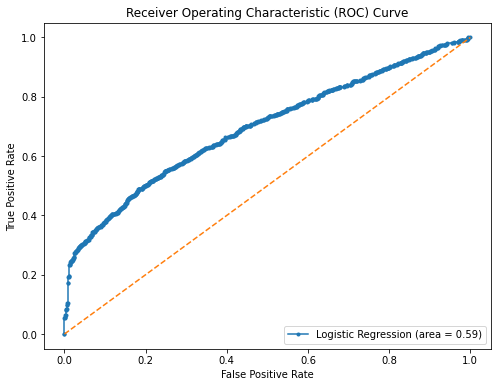

In [33]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_baseline)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.', label='Logistic Regression (area = %0.2f)' % baseline_roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

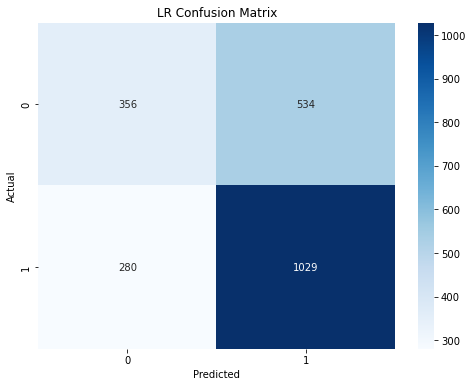

In [34]:
# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_baseline)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LR Confusion Matrix')
plt.show()

### Logistic Regression Hyperparameter Tuning

In [35]:
# Define parameter grid for hyperparameter tuning
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100], # Regularization parameter
    'classifier__penalty': ['l1', 'l2'], # Regularization type
    'classifier__solver': ['lbfgs', 'liblinear'], # Optimization algorithm
    'classifier__class_weight': [None, 'balanced'], # Weights associated with classes
    'classifier__max_iter': [100, 200, 500, 1000], # Maximum number of iterations
    'classifier__tol': [1e-4, 1e-3, 1e-2] # Tolerance for stopping criteria
}

In [36]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(baseline_logistic_model, param_grid, cv=10, scoring='recall')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['customer_care_calls',
                                                                          'customer_rating',
                                                                          'cost_of_the_product',
                                                                          'prior_purchases',
                                                                          'weight_in_gms']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['warehouse_block',
                                                                          'mode_of_shipment',
                                                                          'product_importance',
                                                                          'gender'])])),
                                       ('classifier',
                                        LogisticRegression(random_state=42))]),
             param_grid={'classifier__C': [0.01, 0.1, 1, 10, 100],
                         'classifier__class_weight': [None, 'balanced'],
                         'classifier__max_iter': [100, 200, 500, 1000],
                         'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['lbfgs', 'liblinear'],
                         'classifier__tol': [0.0001, 0.001, 0.01]},
             scoring='recall')

In [37]:
# Best model after tuning
best_model = grid_search.best_estimator_
print(f'Best Model: {best_model}')

# Make predictions with the best model
y_pred_best = best_model.predict(X_test)
y_prob_best = best_model.predict_proba(X_test)[:, 1]

roc_auc_best = roc_auc_score(y_test, y_prob_best)

# Classification report
print('Tuned Model Metrics:')
print(classification_report(y_test, y_pred_best))

# For inputs to the average probability and voting classifiers at the end of the notebook
y_test_pred_LogReg = y_pred_best
y_test_prob_LogReg = y_prob_best

LogReg_accuracy = accuracy_score(y_test, y_pred_best)
LogReg_recall = recall_score(y_test, y_pred_best)
LogReg_precision = precision_score(y_test, y_pred_best)
LogReg_f1 = f1_score(y_test, y_pred_best)

Best Model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['customer_care_calls',
                                                   'customer_rating',
                                                   'cost_of_the_product',
                                                   'prior_purchases',
                                                   'weight_in_gms']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['warehouse_block',
                                                   'mode_of_shipment',
                                                   'product_importance',
                                                   'gender'])])),
                (

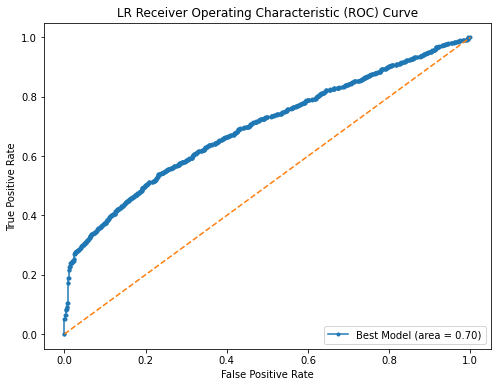

In [38]:
# Plot ROC curve for the best model
fpr_best, tpr_best, _ = roc_curve(y_test, y_prob_best)
plt.figure(figsize=(8, 6))
plt.plot(fpr_best, tpr_best, marker='.', label='Best Model (area = %0.2f)' % roc_auc_best)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LR Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

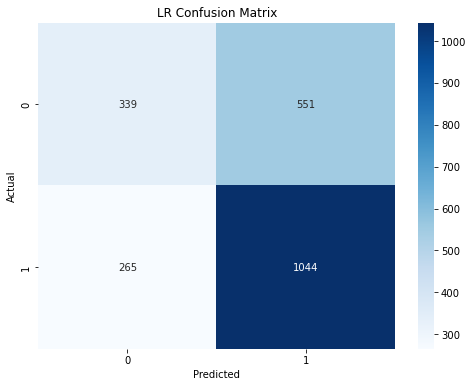

In [39]:
# Display confusion matrix for the best model
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LR Confusion Matrix')
plt.show()

### Decision Tree

In [40]:
# Define the transformer for one-hot encoding
column_transformer = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(), categorical_cols)
    ],
    remainder='passthrough'
)

In [41]:
# Fit the transformer on the training data only and transform X_train
X_train_encoded = column_transformer.fit_transform(X_train)

# Transform X_test using the already fitted transformer
X_test_encoded = column_transformer.transform(X_test)

# Get the new column names after one-hot encoding
encoded_columns = column_transformer.named_transformers_['encoder'].get_feature_names_out(categorical_cols)
new_columns = list(encoded_columns) + [col for col in X_train.columns if col not in categorical_cols]

# Convert the transformed arrays back to DataFrames
X_train = pd.DataFrame(X_train_encoded, columns=new_columns, index=X_train.index)
X_test = pd.DataFrame(X_test_encoded, columns=new_columns, index=X_test.index)

# Get the column names of X for labeling graphs later
X_names = X_test.columns

In [42]:
X_train

,warehouse_block_A,warehouse_block_B,warehouse_block_C,warehouse_block_D,warehouse_block_F,mode_of_shipment_Flight,mode_of_shipment_Road,mode_of_shipment_Ship,product_importance_high,product_importance_low,product_importance_medium,gender_F,gender_M,customer_care_calls,customer_rating,cost_of_the_product,prior_purchases,weight_in_gms
5856,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,3.00,4.00,203.00,2.00,5735.00
4715,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,3.00,3.00,204.00,4.00,4712.00
8684,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,3.00,5.00,205.00,3.00,4565.00
300,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,5.00,3.00,127.00,3.00,1446.00
3465,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,4.00,4.00,202.00,3.00,4299.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5742,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,3.00,1.00,174.00,3.00,4318.00
5199,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,5.00,4.00,249.00,3.00,4397.00
5398,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,4.00,3.00,279.00,6.00,5405.00
868,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,3.00,1.00,218.00,3.00,2304.00


In [43]:
# Define parameter grid
tree_model = DecisionTreeClassifier(random_state=42)
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(3, 20),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 5),
    'class_weight': ['balanced', None]
}

In [44]:
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 2176 candidates, totalling 10880 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': range(3, 20),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 10)},
             scoring='roc_auc', verbose=1)

In [45]:
# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Evaluate on Test Data
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Best Parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score: 0.7416787257702595
Test Accuracy: 0.6898590268303775


In [46]:
# Fit the best model from the grid search on the training data
tree_model = best_model
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=4, random_state=42)

In [47]:
# Get the predictions and display the classification report
y_pred_train = tree_model.predict(X_train)
y_pred_test = tree_model.predict(X_test)
print('TRAINING SET CLASSIFICATION REPORT')
print(classification_report(y_train, y_pred_train))
print('-------------------------------------')
print('TEST SET CLASSIFICATION REPORT')
print(classification_report(y_test, y_pred_test))
print('-------------------------------------')
print(f'test_accuracy: {accuracy_score(y_test, y_pred_test)}')
print(f'test_recall: {recall_score(y_test, y_pred_test)}')
print(f'test_precision: {precision_score(y_test, y_pred_test)}')

TRAINING SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.56      0.98      0.72      3546
           1       0.97      0.49      0.65      5246

    accuracy                           0.69      8792
   macro avg       0.77      0.73      0.68      8792
weighted avg       0.81      0.69      0.68      8792

-------------------------------------
TEST SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.57      0.97      0.72       890
           1       0.97      0.50      0.66      1309

    accuracy                           0.69      2199
   macro avg       0.77      0.74      0.69      2199
weighted avg       0.80      0.69      0.68      2199

-------------------------------------
test_accuracy: 0.6898590268303775
test_recall: 0.4965622612681436
test_precision: 0.9658246656760773


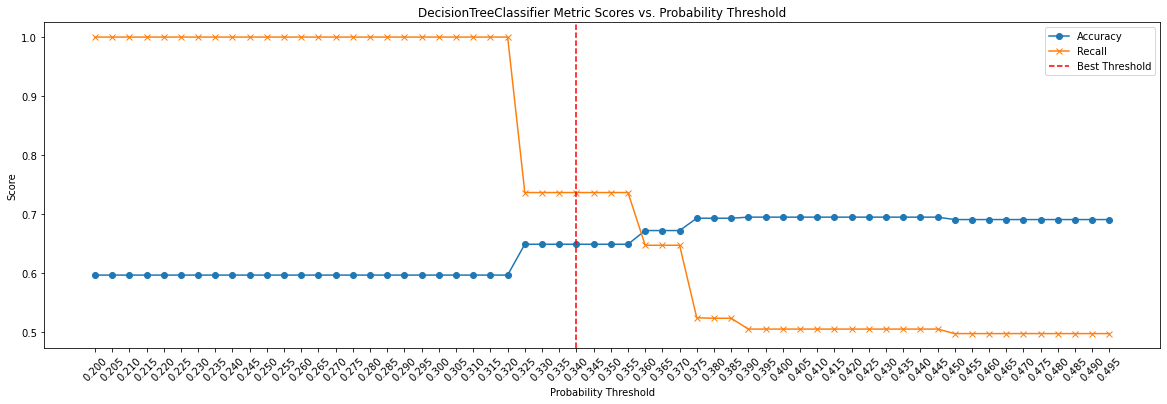

In [48]:
# Create a profile of scores for different probability thresholds
y_test_prob_DecTree = tree_model.predict_proba(X_test)[:, 1]
acc_test = []
recall_test = []
f1_test = []
x_range = np.arange(0.2, 0.5, 0.005)
for prob_threshold in x_range:    
    y_pred_test = (y_test_prob_DecTree > prob_threshold).astype(int)
    acc_test.append(accuracy_score(y_test, y_pred_test))
    recall_test.append(recall_score(y_test, y_pred_test))
    f1_test.append(f1_score(y_test, y_pred_test))
    
# Plotting all three metrics
plt.figure(figsize=(20, 6))
plt.plot(x_range, acc_test, label='Accuracy', marker='o')
plt.plot(x_range, recall_test, label='Recall', marker='x')
#plt.plot(x_range, f1_test, label='F1 Score', marker='^')

# Add a vertical dashed red line to indicate the best threshold
plt.axvline(x=0.340, color='red', linestyle='--', label='Best Threshold')

plt.xlabel('Probability Threshold')
plt.ylabel('Score')
plt.title('DecisionTreeClassifier Metric Scores vs. Probability Threshold')
plt.xticks(x_range)  # Set x-axis ticks to be x_range values
plt.xticks(rotation=45)
plt.legend()
plt.show()

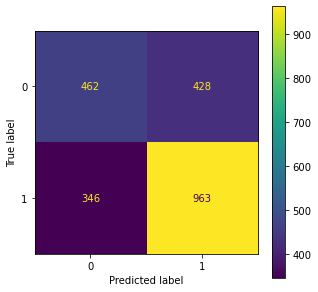

test_accuracy: 0.6480218281036835
test_recall: 0.7356760886172651
test_precision: 0.6923076923076923
test_f1: 0.7133333333333334


In [49]:
# Create a confusion matrix for the best threshold
prob_threshold = 0.340
y_test_prob = tree_model.predict_proba(X_test)[:, 1]
y_pred_test = (y_test_prob > prob_threshold).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred_test)
# Create a figure and a set of subplots with custom size
fig, ax = plt.subplots(figsize=(5, 5))  # Adjust the figure size as needed

# Plot the confusion matrix on the created axes
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(ax=ax)  # Pass the axes to the plot method

plt.grid(False)  # Disable the grid
plt.show()

DecTree_accuracy = accuracy_score(y_test, y_pred_test)
DecTree_recall = recall_score(y_test, y_pred_test)
DecTree_precision = precision_score(y_test, y_pred_test)
DecTree_f1 = f1_score(y_test, y_pred_test)

print(f'test_accuracy: {DecTree_accuracy}')
print(f'test_recall: {DecTree_recall}')
print(f'test_precision: {DecTree_precision}')
print(f'test_f1: {DecTree_f1}')

y_test_pred_DecTree = y_pred_test

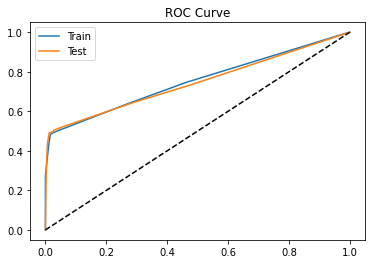

In [50]:
# Get the probabilities and display the ROC curve
y_test_score = tree_model.predict_proba(X_test)[:, 1]
y_train_score = tree_model.predict_proba(X_train)[:, 1]

test_fpr, test_tpr, thresholds = roc_curve(y_test, y_test_score)
train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

# Plot the ROC curves
plt.plot(train_fpr, train_tpr, label='Train')
plt.plot(test_fpr, test_tpr, label='Test')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.title('ROC Curve')
plt.show()

### LazyClassifier to identify other high performing models to evaluate

In [51]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

models

100%|██████████| 29/29 [00:24<00:00,  1.18it/s]

[LightGBM] [Info] Number of positive: 5246, number of negative: 3546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 532
[LightGBM] [Info] Number of data points in the train set: 8792, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.596679 -> initscore=0.391646
[LightGBM] [Info] Start training from score 0.391646


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.66,0.68,0.68,0.67,0.18
BaggingClassifier,0.67,0.68,0.68,0.67,0.24
RandomForestClassifier,0.66,0.65,0.65,0.66,0.76
XGBClassifier,0.65,0.65,0.65,0.66,0.31
NearestCentroid,0.64,0.64,0.64,0.64,0.02
AdaBoostClassifier,0.65,0.63,0.63,0.65,0.26
ExtraTreesClassifier,0.65,0.63,0.63,0.65,0.94
NuSVC,0.64,0.63,0.63,0.64,6.50
SVC,0.64,0.62,0.62,0.64,3.42


### Grid Search LGBM Classifier

In [55]:
#instantiate LGBMClassifier
estimator = LGBMClassifier(random_state=42, verbose=-1)

# Define parameter grid
param_grid = {
    'num_leaves': [15, 31, 63],  # Reduced the range and maximum number
    'max_depth': [5, 10, 15],  # Lowered maximum depth
    'learning_rate': [0.01, 0.05, 0.1],  # Adjusted learning rates for finer steps
    'n_estimators': [100, 200, 300],  # Adjusted number of estimators
    'lambda_l1': [0, 1, 10],  # Added L1 regularization
    'lambda_l2': [0, 1, 10],  # Added L2 regularization
}

In [56]:
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5, scoring='roc_auc')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=42, verbose=-1),
             param_grid={'lambda_l1': [0, 1, 10], 'lambda_l2': [0, 1, 10],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [5, 10, 15],
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [15, 31, 63]},
             scoring='roc_auc')

In [57]:
# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Evaluate on Test Data
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Best Parameters: {'lambda_l1': 10, 'lambda_l2': 10, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 15}
Best Score: 0.7443741839173293
Test Accuracy: 0.6580263756252842


In [58]:
# Fit the best model from the grid search on the training data
tree_model = best_model
tree_model.fit(X_train, y_train)

LGBMClassifier(lambda_l1=10, lambda_l2=10, learning_rate=0.01, max_depth=5,
               num_leaves=15, random_state=42, verbose=-1)

In [59]:
# Get the predictions and display the classification report
y_pred_train = tree_model.predict(X_train)
y_pred_test = tree_model.predict(X_test)
print('TRAINING SET CLASSIFICATION REPORT')
print(classification_report(y_train, y_pred_train))
print('-------------------------------------')
print('TEST SET CLASSIFICATION REPORT')
print(classification_report(y_test, y_pred_test))
print('-------------------------------------')
print(f'test_accuracy: {accuracy_score(y_test, y_pred_test)}')
print(f'test_recall: {recall_score(y_test, y_pred_test)}')
print(f'test_precision: {precision_score(y_test, y_pred_test)}')

TRAINING SET CLASSIFICATION REPORT


              precision    recall  f1-score   support

           0       0.59      0.62      0.60      3546
           1       0.73      0.71      0.72      5246

    accuracy                           0.67      8792
   macro avg       0.66      0.66      0.66      8792
weighted avg       0.67      0.67      0.67      8792

-------------------------------------
TEST SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.57      0.60      0.59       890
           1       0.72      0.70      0.71      1309

    accuracy                           0.66      2199
   macro avg       0.65      0.65      0.65      2199
weighted avg       0.66      0.66      0.66      2199

-------------------------------------
test_accuracy: 0.6580263756252842
test_recall: 0.6974789915966386
test_precision: 0.7194641449960599


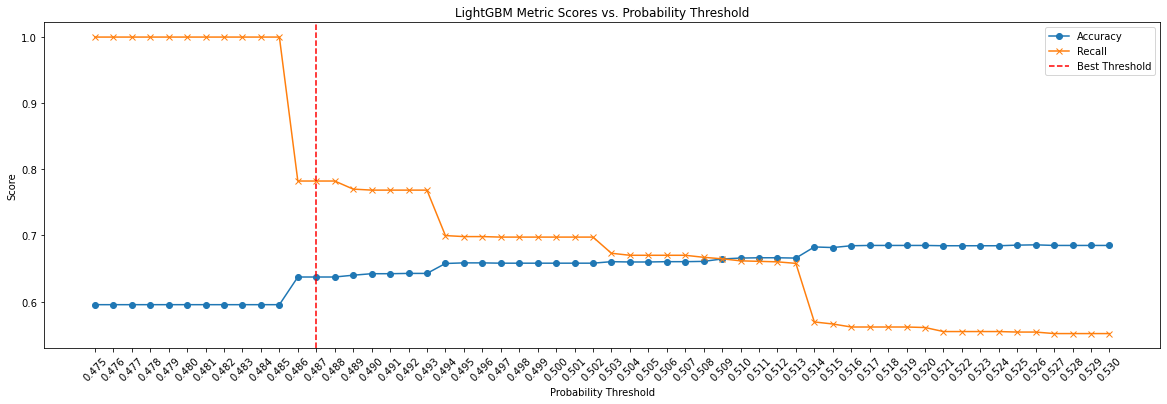

In [60]:
# Create a profile of scores for different probability thresholds
y_test_prob_LGBM = tree_model.predict_proba(X_test)[:, 1]
acc_test = []
recall_test = []
f1_test = []
x_range = np.arange(0.475, 0.530, 0.001)
for prob_threshold in x_range:    
    y_pred_test = (y_test_prob_LGBM > prob_threshold).astype(int)
    acc_test.append(accuracy_score(y_test, y_pred_test))
    recall_test.append(recall_score(y_test, y_pred_test))
    f1_test.append(f1_score(y_test, y_pred_test))
    
# Plotting all three metrics
plt.figure(figsize=(20, 6))
plt.plot(x_range, acc_test, label='Accuracy', marker='o')
plt.plot(x_range, recall_test, label='Recall', marker='x')
#plt.plot(x_range, f1_test, label='F1 Score', marker='^')

# Add a vertical dashed red line to indicate the best threshold
plt.axvline(x=0.487, color='red', linestyle='--', label='Best Threshold')


plt.xlabel('Probability Threshold')
plt.ylabel('Score')
plt.title('LightGBM Metric Scores vs. Probability Threshold')
plt.xticks(x_range)  # Set x-axis ticks to be x_range values
plt.xticks(rotation=45)
plt.legend()
plt.show()

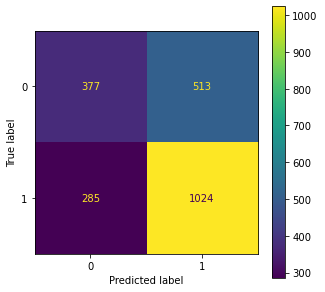

test_accuracy: 0.6371077762619373
test_recall: 0.7822765469824293
test_precision: 0.6662329212752115
test_f1: 0.7196064652143359


In [61]:

# Display confusion matrix for the best model
prob_threshold = 0.487
y_test_prob = tree_model.predict_proba(X_test)[:, 1]
y_pred_test = (y_test_prob > prob_threshold).astype(int)

#y_pred_test = tree_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
# Create a figure and a set of subplots with custom size
fig, ax = plt.subplots(figsize=(5, 5))  # Adjust the figure size as needed

# Plot the confusion matrix on the created axes
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(ax=ax)  # Pass the axes to the plot method

plt.grid(False)  # Disable the grid
plt.show()

LGBM_accuracy = accuracy_score(y_test, y_pred_test)
LGBM_recall = recall_score(y_test, y_pred_test)
LGBM_precision = precision_score(y_test, y_pred_test)
LGBM_f1 = f1_score(y_test, y_pred_test)

print(f'test_accuracy: {LGBM_accuracy}')
print(f'test_recall: {LGBM_recall}')
print(f'test_precision: {LGBM_precision}')
print(f'test_f1: {LGBM_f1}')

y_test_pred_LGBM = y_pred_test

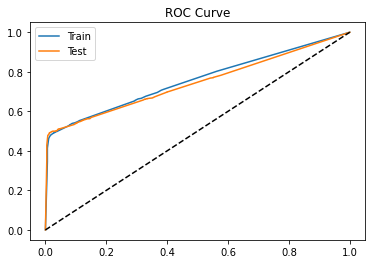

In [62]:
# Get the statistics and display the ROC curve
y_test_score = tree_model.predict_proba(X_test)[:, 1]
y_train_score = tree_model.predict_proba(X_train)[:, 1]

test_fpr, test_tpr, thresholds = roc_curve(y_test, y_test_score)
train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

# Plot the ROC curves
plt.plot(train_fpr, train_tpr, label='Train')
plt.plot(test_fpr, test_tpr, label='Test')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.title('ROC Curve')
plt.show()

### Grid Search Bagging Classifier

In [63]:
#instantiate BaggingClassifier, base estimator is DecisionTreeClassifier
estimator = BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=42)

# Define parameter grid
param_grid = {
    'base_estimator__max_depth': [3, 5, 7],  
    'n_estimators': [30, 50, 70],  
    'max_samples': [0.4, 0.5, 0.6],  
    'max_features': [0.4, 0.5, 0.6], 
    'base_estimator__min_samples_split': [2, 4, 6],
    'base_estimator__min_samples_leaf': [1, 2, 3]
}

In [64]:
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5, scoring='roc_auc')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                         random_state=42),
             param_grid={'base_estimator__max_depth': [3, 5, 7],
                         'base_estimator__min_samples_leaf': [1, 2, 3],
                         'base_estimator__min_samples_split': [2, 4, 6],
                         'max_features': [0.4, 0.5, 0.6],
                         'max_samples': [0.4, 0.5, 0.6],
                         'n_estimators': [30, 50, 70]},
             scoring='roc_auc')

In [65]:
# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Evaluate on Test Data
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Best Parameters: {'base_estimator__max_depth': 3, 'base_estimator__min_samples_leaf': 3, 'base_estimator__min_samples_split': 2, 'max_features': 0.6, 'max_samples': 0.4, 'n_estimators': 30}
Best Score: 0.7406631503141552
Test Accuracy: 0.6152796725784447


In [66]:
# # Fit the best model from the grid search on the training data
tree_model = best_model
tree_model.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                        min_samples_leaf=3),
                  max_features=0.6, max_samples=0.4, n_estimators=30,
                  random_state=42)

In [67]:
# Get the predictions and display the classification report
y_pred_train = tree_model.predict(X_train)
y_pred_test = tree_model.predict(X_test)
print('TRAINING SET CLASSIFICATION REPORT')
print(classification_report(y_train, y_pred_train))
print('-------------------------------------')
print('TEST SET CLASSIFICATION REPORT')
print(classification_report(y_test, y_pred_test))
print('-------------------------------------')
print(f'test_accuracy: {accuracy_score(y_test, y_pred_test)}')
print(f'test_recall: {recall_score(y_test, y_pred_test)}')
print(f'test_precision: {precision_score(y_test, y_pred_test)}')


TRAINING SET CLASSIFICATION REPORT


              precision    recall  f1-score   support

           0       0.62      0.16      0.26      3546
           1       0.62      0.93      0.75      5246

    accuracy                           0.62      8792
   macro avg       0.62      0.55      0.50      8792
weighted avg       0.62      0.62      0.55      8792

-------------------------------------
TEST SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.60      0.15      0.24       890
           1       0.62      0.93      0.74      1309

    accuracy                           0.62      2199
   macro avg       0.61      0.54      0.49      2199
weighted avg       0.61      0.62      0.54      2199

-------------------------------------
test_accuracy: 0.6152796725784447
test_recall: 0.932009167303285
test_precision: 0.6170966110268084


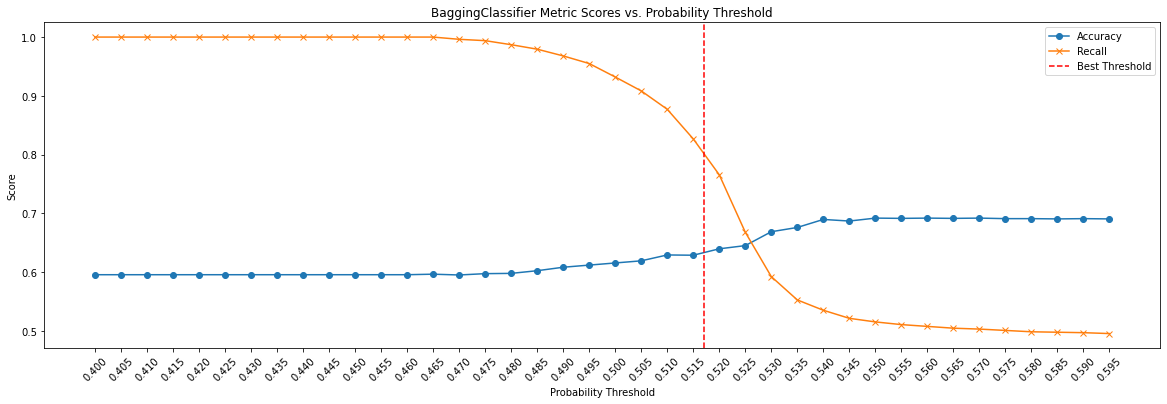

In [68]:
# Create a profile of scores for different probability thresholds
y_test_prob_bagging = tree_model.predict_proba(X_test)[:, 1]
acc_test = []
recall_test = []
f1_test = []
x_range = np.arange(0.4, 0.6, 0.005)
for prob_threshold in x_range:    
    y_pred_test = (y_test_prob_bagging > prob_threshold).astype(int)
    acc_test.append(accuracy_score(y_test, y_pred_test))
    recall_test.append(recall_score(y_test, y_pred_test))
    f1_test.append(f1_score(y_test, y_pred_test))
    
# Plotting all three metrics
plt.figure(figsize=(20, 6))
plt.plot(x_range, acc_test, label='Accuracy', marker='o')
plt.plot(x_range, recall_test, label='Recall', marker='x')
#plt.plot(x_range, f1_test, label='F1 Score', marker='^')

# Add a vertical dashed red line to indicate the best threshold
best_threshold = 0.517
plt.axvline(x=best_threshold, color='red', linestyle='--', label='Best Threshold')

plt.xlabel('Probability Threshold')
plt.ylabel('Score')
plt.title('BaggingClassifier Metric Scores vs. Probability Threshold')
plt.xticks(x_range)  # Set x-axis ticks to be x_range values
plt.xticks(rotation=45)
plt.legend()
plt.show()

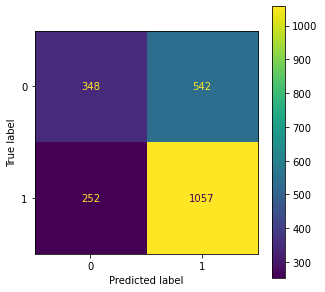

test_accuracy: 0.6389267849022283
test_recall: 0.8074866310160428
test_precision: 0.6610381488430269
test_f1: 0.7269601100412655


In [69]:

# Get the best threshold and display the scores
prob_threshold = best_threshold
y_test_prob = tree_model.predict_proba(X_test)[:, 1]
y_pred_test = (y_test_prob > prob_threshold).astype(int)

#y_pred_test = tree_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
# Create a figure and a set of subplots with custom size
fig, ax = plt.subplots(figsize=(5, 5))  # Adjust the figure size as needed

# Plot the confusion matrix on the created axes
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(ax=ax)  # Pass the axes to the plot method

plt.grid(False)  # Disable the grid
plt.show()
bagging_accuracy = accuracy_score(y_test, y_pred_test)
bagging_recall = recall_score(y_test, y_pred_test)
bagging_precision = precision_score(y_test, y_pred_test)
bagging_f1 = f1_score(y_test, y_pred_test)

print(f'test_accuracy: {bagging_accuracy}')
print(f'test_recall: {bagging_recall}')
print(f'test_precision: {bagging_precision}')
print(f'test_f1: {bagging_f1}')

y_test_pred_Bagging = y_pred_test

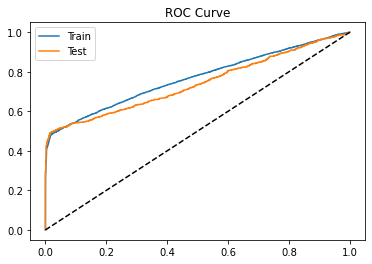

In [70]:
# Get this statistic for the ROC curve
y_test_score = tree_model.predict_proba(X_test)[:, 1]
y_train_score = tree_model.predict_proba(X_train)[:, 1]

test_fpr, test_tpr, thresholds = roc_curve(y_test, y_test_score)
train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

# Plot the ROC curves
plt.plot(train_fpr, train_tpr, label='Train')
plt.plot(test_fpr, test_tpr, label='Test')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.title('ROC Curve')
plt.show()

### Average Probability Prediction

In [71]:
# Define a function that takes the probabilities of all the models, and a threshold, and returns the predictions
def average_probs_predict(y_probs, threshold):
    average_probs = np.mean(y_probs, axis=0)
    y_pred_test = (average_probs > threshold).astype(int)
    return y_pred_test, average_probs

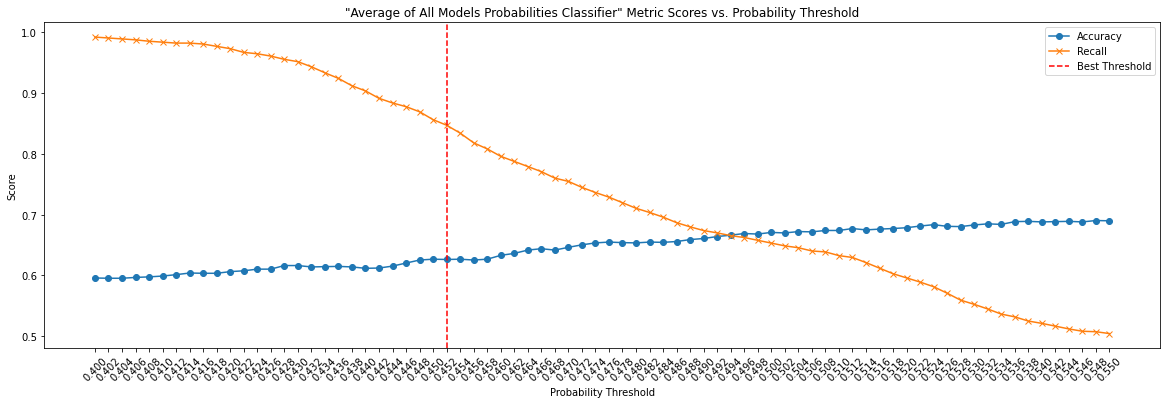

In [72]:
# Create a profile of scores for different probability thresholds
probs_list = [y_test_prob_DecTree, y_test_prob_LGBM, y_test_prob_bagging, y_test_prob_LogReg]

acc_test = []
recall_test = []
f1_test = []
x_range = np.arange(0.4, 0.55, 0.002)
for prob_threshold in x_range:
    y_pred_test, y_prob_test = average_probs_predict(probs_list, prob_threshold)
    acc_test.append(accuracy_score(y_test, y_pred_test))
    recall_test.append(recall_score(y_test, y_pred_test))
    f1_test.append(f1_score(y_test, y_pred_test))
    
# Plotting all three metrics
plt.figure(figsize=(20, 6))
plt.plot(x_range, acc_test, label='Accuracy', marker='o')
plt.plot(x_range, recall_test, label='Recall', marker='x')
#plt.plot(x_range, f1_test, label='F1 Score', marker='^')

# Add a vertical dashed red line to indicate the best threshold
best_threshold = 0.452
plt.axvline(x=best_threshold, color='red', linestyle='--', label='Best Threshold')

plt.xlabel('Probability Threshold')
plt.ylabel('Score')
plt.title('"Average of All Models Probabilities Classifier" Metric Scores vs. Probability Threshold')
plt.xticks(x_range)  # Set x-axis ticks to be x_range values
plt.xticks(rotation=45)
plt.legend()
plt.show()

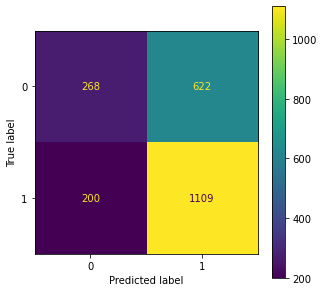

test_accuracy: 0.626193724420191
test_recall: 0.8472116119174943
test_precision: 0.6406701328711727
test_f1: 0.7296052631578948


In [73]:

# Get the best threshold and display the scores
prob_threshold = best_threshold
y_pred_test, y_prob_test = average_probs_predict(probs_list, prob_threshold)

#y_pred_test = tree_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
# Create a figure and a set of subplots with custom size
fig, ax = plt.subplots(figsize=(5, 5))  # Adjust the figure size as needed

# Plot the confusion matrix on the created axes
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(ax=ax)  # Pass the axes to the plot method

plt.grid(False)  # Disable the grid
plt.show()

avg_prob_accuracy = accuracy_score(y_test, y_pred_test)
avg_prob_recall = recall_score(y_test, y_pred_test)
avg_prob_precision = precision_score(y_test, y_pred_test)
avg_prob_f1 = f1_score(y_test, y_pred_test)

print(f'test_accuracy: {avg_prob_accuracy}')
print(f'test_recall: {avg_prob_recall}')
print(f'test_precision: {avg_prob_precision}')
print(f'test_f1: {avg_prob_f1}')


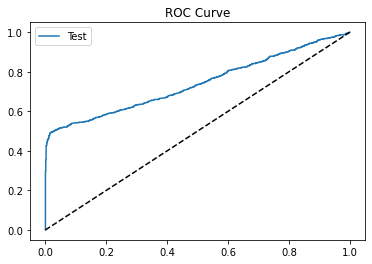

In [74]:
# Get the probabilities for the ROC curve
test_fpr, test_tpr, thresholds = roc_curve(y_test, y_test_score)


# Plot the ROC curves
plt.plot(test_fpr, test_tpr, label='Test')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.title('ROC Curve')
plt.show()

### Vote Predictions

In [75]:
# Define a function that takes the prediction from each model and returns the majority vote
def vote_predict(y_preds, tie_breaker=1):
    final_votes = []
    votes = np.mean(y_preds, axis=0)
    for vote in votes:
        if vote == 0.5:
            final_votes.append(tie_breaker)
        elif vote > 0.5:
            final_votes.append(1)
        else:
            final_votes.append(0)
    return final_votes

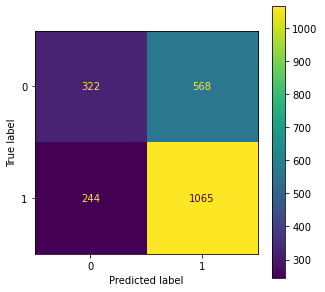

test_accuracy: 0.6307412460209186
test_recall: 0.813598166539343
test_precision: 0.6521739130434783
test_f1: 0.7239972807613868


In [76]:
# Get the predictions from each model and input them into the vote_predict function
preds_list = [y_test_pred_DecTree, y_test_pred_LGBM, y_test_pred_Bagging, y_test_pred_LogReg]
y_pred_test = vote_predict(preds_list, tie_breaker=1)

#y_pred_test = tree_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
# Create a figure and a set of subplots with custom size
fig, ax = plt.subplots(figsize=(5, 5))  # Adjust the figure size as needed

# Plot the confusion matrix on the created axes
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(ax=ax)  # Pass the axes to the plot method

plt.grid(False)  # Disable the grid
plt.show()
vote_accuracy = accuracy_score(y_test, y_pred_test)
vote_recall = recall_score(y_test, y_pred_test)
vote_precision = precision_score(y_test, y_pred_test)
vote_f1 = f1_score(y_test, y_pred_test)

print(f'test_accuracy: {vote_accuracy}')
print(f'test_recall: {vote_recall}')
print(f'test_precision: {vote_precision}')
print(f'test_f1: {vote_f1}')


## Analyze All Classification Models

In [77]:
column_names = ['Classifier', 'Precision', 'F1', 'Accuracy', 'Recall']
data = [['Logistic Regression', LogReg_precision, LogReg_f1, LogReg_accuracy, LogReg_recall],
        ['Decision Tree', DecTree_precision, DecTree_f1, DecTree_accuracy, DecTree_recall],
        ['LightGBM Classifier', LGBM_precision, LGBM_f1, LGBM_accuracy, LGBM_recall],
        ['BaggingClassifier', bagging_precision, bagging_f1, bagging_accuracy, bagging_recall],
        ['Avg Probability Classifier', avg_prob_precision, avg_prob_f1, avg_prob_accuracy, avg_prob_recall],
        ['Voting Classifier', vote_precision, vote_f1, vote_accuracy, vote_recall]]

final_results_df = pd.DataFrame(data, columns=column_names).sort_values(by=['Recall', 'Accuracy'], ascending=[False, False])

display(final_results_df.style.hide_index())

Classifier,Precision,F1,Accuracy,Recall
Avg Probability Classifier,0.64,0.73,0.63,0.85
Voting Classifier,0.65,0.72,0.63,0.81
BaggingClassifier,0.66,0.73,0.64,0.81
Logistic Regression,0.65,0.72,0.63,0.80
LightGBM Classifier,0.67,0.72,0.64,0.78
Decision Tree,0.69,0.71,0.65,0.74


---

## Conclusions
Best Model: Average Probability Classifier:
- Highest Primary Metric: Recall
- Accuracy was not the highest, but comparable to other models
- Combines predictions from multiple models
- Final Metrics:

<img src="./Images/final_metrics.png" alt="description" width="70%" height="auto">
 
## Recommendations
1. Back to square 1: Business Understanding <-> Data Understanding. Address and correct problems in the raw data.
2. Improve data acquisition methods to increase performance of future models
3. Implement the Average Probability Classification model as a stop-gap to avoid late shipments until items 1 and 2 can be addressed

## Next Steps
1. Prioritize focus on Business/Data Understanding; answer:
   - Are discounts offered over $10 due to prior knowledge lateness?
   - Root cause(s) for segmentation in shipment weight data 
   - Root cause(s) for segmentation in ID… is the data time sequential?
2. Investigate improving data acquisition: 
   - What data can we gather that will help us better predict lateness?
3. Deployment of Average Probability Classification, predict late shipments:
   - Flag potential late shipments for expediting delivery
   - If lateness cannot be corrected, preemptively engage with customer to inform, offer discount, etc.